# Gibbs / Kandler 1955


For this part of the workshop we are solving an actual, small scientific puzzle. When Martin Gibbs, Otto Kandler and others were investigating the pathway now known as the Calvin-Benson-Bassham cycle, they used radioactive carbon to trace where the fixated carbon dioxide ended up in the photosynthetic organism. One finding they could not explain at that time is the "asymmetric distribution of C14 in sugars formed during photosynthesis". As a quick reminder, this is a scheme of the CBB cycle:

![cbb-horizontal.svg](cbb-horizontal.png)



If you look at the data from the experiments below, you might notice that certain asymmetries in the radioactively marked carbons inside of glucose. 

![label-asymmetries.png](label-asymmetries.png)

There are a few patterns of asymmetries you can find through multiple experiments. We will focus on the C4 / C3 asymmetry today:


| Time   | **C4 / C3** | C2 / C5 | C1 / C6 |
| ------ | ----------- | ------- | ------- |
| 10 s   | **1.34**    | 2.7     | 1.56    |
| 60 s   | **1.36**    | 2.74    | 2.52    |
| 45 min | **1.04**    | 1.01    | 0.97    |


For now we will assume, that the CBB cycle in the experiments above was in steady state. This allows us to greatly reduce the amount of computational time we are going to need, but might not always be applicable. Let's calculate the steady state first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from modelbase.ode import Simulator
from poolman import get_model

# Metabolic model

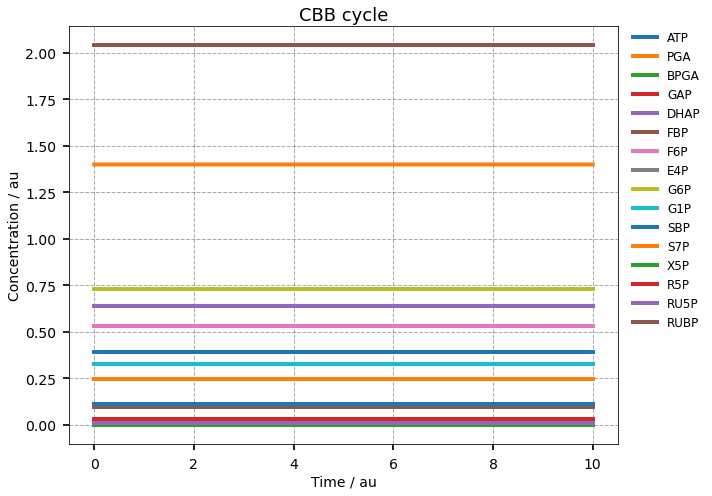

In [2]:
m = get_model()
s = Simulator(m)
s.initialise(
    {
        "PGA": 1.4,
        "BPGA": 0.001,
        "GAP": 0.032,
        "DHAP": 0.64,
        "FBP": 0.097,
        "F6P": 0.53,
        "E4P": 0.02,
        "G6P": 0.73,
        "G1P": 0.33,
        "SBP": 0.114,
        "S7P": 0.248,
        "X5P": 0.021,
        "R5P": 0.034,
        "RUBP": 2.04,
        "RU5P": 0.012,
        "ATP": 0.39,
    }
)
t, y = s.simulate(10)
fig, ax = s.plot(xlabel="Time / au", ylabel="Concentration / au", title="CBB cycle")
plt.show()

# Save concentrations and fluxes for label model
y_ss = dict(s.get_results_df().iloc[-1])
v_ss = dict(s.get_fluxes_df().iloc[-1])

# Label model (metabolic steady state)

We will use carbon maps like the following

<img src="carbon-maps.png" style="max-width: 300px"></img>


for every reaction of the Calvin-Benson-Bassham cycle to build the labeled model. First, we need to know how many carbons each compound holds

In [3]:
label_compounds = {
    "PGA": 3,
    "BPGA": 3,
    "GAP": 3,
    "DHAP": 3,
    "FBP": 6,
    "F6P": 6,
    "E4P": 4,
    "G6P": 6,
    "G1P": 6,
    "SBP": 7,
    "S7P": 7,
    "X5P": 5,
    "R5P": 5,
    "RU5P": 5,
    "RUBP": 5,
}

Then we build up the following labeled variant

![cbb-cycle](cbbcl-full.png)

In [4]:
label_maps = {
    "v1": [2, 1, 0, 5, 3, 4],
    "v2f": [0, 1, 2],
    "v2r": [0, 1, 2],
    "v3f": [0, 1, 2],
    "v3r": [0, 1, 2],
    "v4f": [2, 1, 0],
    "v4r": [2, 1, 0],
    "v5f": [0, 1, 2, 3, 4, 5],
    "v5r": [0, 1, 2, 3, 4, 5],
    "v6": [0, 1, 2, 3, 4, 5],
    "v7f": [0, 1, 6, 7, 8, 2, 3, 4, 5],
    "v7r": [0, 1, 5, 6, 7, 8, 2, 3, 4],
    "v8f": [0, 1, 2, 3, 4, 5, 6],
    "v8r": [0, 1, 2, 3, 4, 5, 6],
    "v9": [0, 1, 2, 3, 4, 5, 6],
    "v10f": [0, 1, 7, 8, 9, 2, 3, 4, 5, 6],
    "v10r": [0, 1, 5, 6, 7, 8, 9, 2, 3, 4],
    "v11f": [0, 1, 2, 3, 4],
    "v11r": [0, 1, 2, 3, 4],
    "v12f": [0, 1, 2, 3, 4],
    "v12r": [0, 1, 2, 3, 4],
    "v13": [0, 1, 2, 3, 4],
    "v14f": [0, 1, 2, 3, 4, 5],
    "v14r": [0, 1, 2, 3, 4, 5],
    "v15f": [0, 1, 2, 3, 4, 5],
    "v15r": [0, 1, 2, 3, 4, 5],
    "vSt": [0, 1, 2, 3, 4, 5],
    "vPGA_out": [0, 1, 2],
    "vGAP_out": [0, 1, 2],
    "vDHAP_out": [0, 1, 2],
}

## Simulation

With that done, we can check out how the system behaves

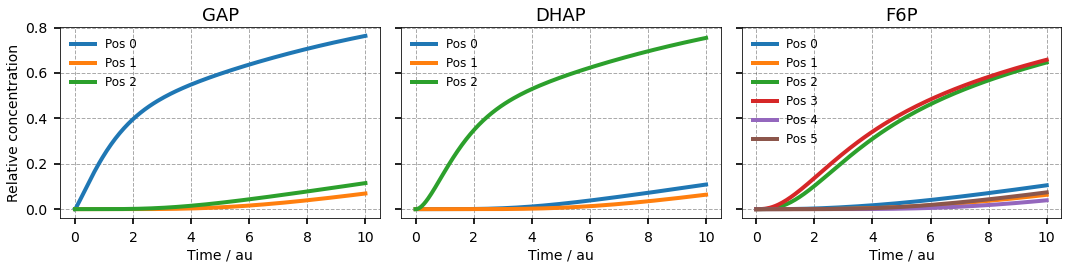

In [5]:
m = get_model()
lm = m.to_linear_labelmodel(
    labelcompounds=label_compounds,
    labelmaps=label_maps,
)


s = Simulator(lm)
s.initialise(lm.generate_y0(), y_ss, v_ss)

t, y = s.simulate(10)
fig, ax = s.plot_label_distribution_grid(
    compounds=["GAP", "DHAP", "F6P"],
    sharey=True,
    xlabels="Time / au",
)
plt.show()

In [6]:
t_start_idx = np.searchsorted(t, 1)  # Excluding early very extreme values

fig, ax = plt.subplots()
ax.plot(
    t[t_start_idx:],
    s.get_label_position("F6P", 3)[t_start_idx:]
    / s.get_label_position("F6P", 2)[t_start_idx:],
)
ax.set(xlabel="Time / au", ylabel="C4/C3 asymmetry")
plt.show()

Just like the experimental data we can see a clear asymmetry between C4 and C3, which is getting smaller over time. Why is that the case? If we re-visit the diagram from before, we can clearly see that the C3 of FBP is build from the C3 of DHAP, which is in turn build from C1 of GAP. The C4 of FBP on the other hand is directly build by C1 of GAP. Since the only influx of labeled carbons into DHAP is from GAP (SBP -> S7P is practically irreversible), the label percentage of DHAP-C3 can only be $\leq$ GAP-C1. Thus, FBP-C3 can only ever be $\leq$ FBP-C4. Once GAP-C1 approaches saturation, this effect gets smaller, and thus the asymmetry slowly fades away.

![cbbcl-34.png](cbbcl-34.png)

**For the super-interested only**: If you looked closely at the other asymmetries and follow the explanation from above, you will find that the C1/C6 and C2/C5 asymmetries should be the exact opposite as they are found. This is because they were measured in Glucose and thus as F6P have an additional influx route via transketolase (e.g. X5P-C1 -> F6P-C1). If it weren't known by know, this would be really good evidence that transketolase does indeed catalyze the reaction in both directions.

# Optional: Non-steady state labeling

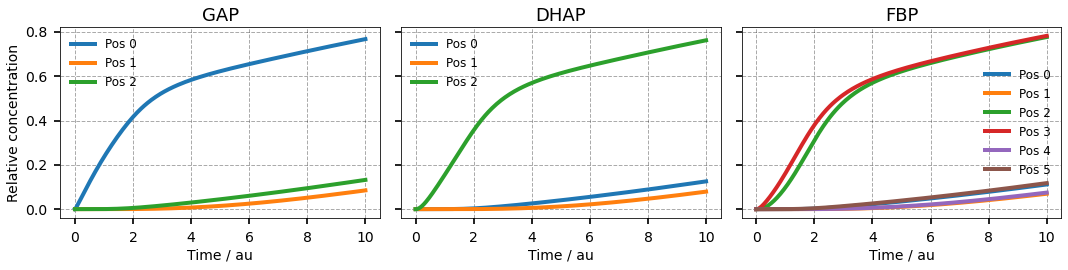

In [7]:
m = get_model()
lm = m.to_labelmodel(
    labelcompounds=label_compounds,
    labelmaps=label_maps,
)

s = Simulator(lm)
s.initialise(lm.generate_y0(y_ss))

t, y = s.simulate(10)
fig, ax = s.plot_label_distribution_grid(
    compounds=["GAP", "DHAP", "FBP"],
    sharey=True,
    xlabels="Time / au",
)
plt.show()

You will have noticed quite a large increase in computational time needed to run this model. The reason for this is simply the size of it

In [8]:
print(len(m.compounds), len(m.rates))
print(len(lm.compounds), len(lm.rates))

16 31
689 4233
